In [104]:
# ===============================
# Librerie per gestione dati e visualizzazione
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates


# ===============================
# Caricamento dei dataset
# ===============================
from sklearn.datasets import fetch_openml
import os
from scipy.io import arff


# ===============================
# Preprocessing, feature selection e valutazione
# ===============================
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    mutual_info_classif,
    RFE,
    VarianceThreshold
)


# ===============================
# Modelli di classificazione
# ===============================
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


# ===============================
# Validazione, metriche e tuning
# ===============================
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
from scipy.stats import loguniform, randint


# ===============================
# Utility e supporto alla visualizzazione
# ===============================
from sklearn.base import clone
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import math
import random


In [105]:
# Costanti globali per garantire riproducibilità e configurabilità
RANDOM_STATE = 42  # Per riproducibilità dei risultati
TEST_SIZE = 0.2    # 20% dei dati per il test set
CV_FOLDS = 5       # 5-fold cross validation

In [106]:
# Seme per il generatore di Python
random.seed(RANDOM_STATE)

# Seme per NumPy (usato internamente da molte funzioni di sklearn)
np.random.seed(RANDOM_STATE)

In [107]:
# =======================
# CARICAMENTO DATASET
# =======================
try:
    data_bunch = fetch_openml(
        name='banknote-authentication',
        as_frame=True,
        parser='auto'
    )
except Exception as e:
    print(f"Errore nel caricamento dati: {e}")

# Copia del DataFrame originale
df = data_bunch.frame.copy()


# =======================
# Gestione colonna target
# =======================
class_column_name = data_bunch.target_names[0]
print(f"Identificata la colonna target: '{class_column_name}'")

if class_column_name != 'class' and class_column_name in df.columns:
    df.rename(columns={class_column_name: 'class'}, inplace=True)
    class_column_name = 'class'


# =======================
# Rinomina delle feature
# =======================
new_column_names = {
    'V1': 'variance',
    'V2': 'skewness',
    'V3': 'curtosis',
    'V4': 'entropy'
}

feature_column_names = ['variance', 'skewness', 'curtosis', 'entropy']
df = df.rename(columns=new_column_names)


# =======================
# Analisi preliminare del dataset
# =======================
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()


Identificata la colonna target: 'Class'

--- Prime 5 righe del DataFrame Combinato ---
   variance  skewness  curtosis  entropy class
0   3.62160    8.6661   -2.8073 -0.44699     1
1   4.54590    8.1674   -2.4586 -1.46210     1
2   3.86600   -2.6383    1.9242  0.10645     1
3   3.45660    9.5228   -4.0112 -3.59440     1
4   0.32924   -4.4552    4.5718 -0.98880     1

--- Informazioni (Tipi di dati e Valori Mancanti) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   variance  1372 non-null   float64 
 1   skewness  1372 non-null   float64 
 2   curtosis  1372 non-null   float64 
 3   entropy   1372 non-null   float64 
 4   class     1372 non-null   category
dtypes: category(1), float64(4)
memory usage: 44.5 KB


Il dataset risulta completo (nessun valore mancante) e interamente numerico. Le scale delle variabili, sebbene non drasticamente differenti, possono beneficiare di una standardizzazione per ottimizzare le performance dei modelli basati su distanza o gradiente. Pertanto, la standardizzazione sarà un passaggio fondamentale.

In [108]:
# =======================
# Controllo dimensioni iniziali
# =======================
print(f"Shape iniziale: {df.shape}")


# =======================
# Gestione valori mancanti
# =======================
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"Valori mancanti:\n{missing[missing > 0]}")
    df = df.dropna()
else:
    print("Nessun valore mancante")


# =======================
# Rimozione feature a varianza nulla o molto bassa
# =======================
X_temp = df.drop('class', axis=1)
var_selector = VarianceThreshold(threshold=0.00)
var_selector.fit(X_temp)

low_var_features = X_temp.columns[~var_selector.get_support()].tolist()
if low_var_features:
    print(f"Feature a bassa varianza rimosse: {low_var_features}")
    df = df.drop(columns=low_var_features)
else:
    print("Nessuna feature a bassa varianza")


# =======================
# Aggiornamento lista delle feature
# =======================
feature_column_names = df.drop(columns=['class']).columns.tolist()


Shape iniziale: (1372, 5)
Nessun valore mancante
Nessuna feature a bassa varianza


# INIZIO ANALISI DEL DATASET

Qui vengono mostrati i grafici per un'analisi esplorativa del dataset. Verranno mostrate le distribuzioni delle feature, la correlazione lineare tra esse e la distribuzione delle classi

### Grafico a torta

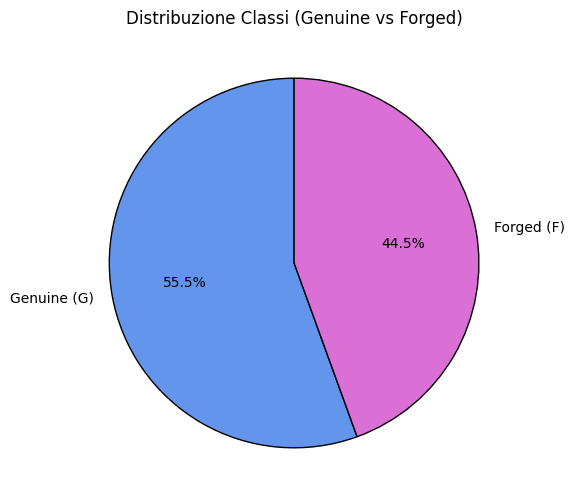

In [109]:
# =======================
# VISUALIZZAZIONI – Grafico a Torta
# =======================

# Mappatura delle classi e colori
class_map = {'1': 'Genuine (G)', '2': 'Forged (F)'}
color_map_dict = {'Genuine (G)': 'cornflowerblue', 'Forged (F)': 'orchid'}


# Preparazione del DataFrame per la visualizzazione
df_plot = df.copy()
df_plot['Authenticity_Label'] = df['class'].map(class_map)
df_plot = df_plot.drop(columns=['class'])


# Creazione del grafico a torta (distribuzione delle classi)
plt.figure(figsize=(6, 6))

# Conteggio delle classi
counts = df_plot['Authenticity_Label'].value_counts()

# Assegnazione colori in base alle etichette
colors = [color_map_dict[label] for label in counts.index]

# Plot
counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (Genuine vs Forged)')
plt.ylabel('')
plt.show()


Il grafico a torta mostra che la distribuzione delle classi è relativamente bilanciata, con la categoria 'Genuine (G)' che rappresenta il 55.5% delle osservazioni e la categoria 'Forged (F)' il 44.5%. Sebbene l'asimmetria non sia pronunciata come in altri contesti, la valutazione del modello dovrà comunque basarsi su metriche più robuste come l'F1-Score, in quanto la corretta identificazione delle banconote contraffatte (seppur non una classe estremamente minoritaria, ma di elevata rilevanza) è cruciale. L'utilizzo di queste metriche garantirà una performance affidabile, specialmente nella capacità di rilevare la classe di interesse.

### Grafico coordinate parallele

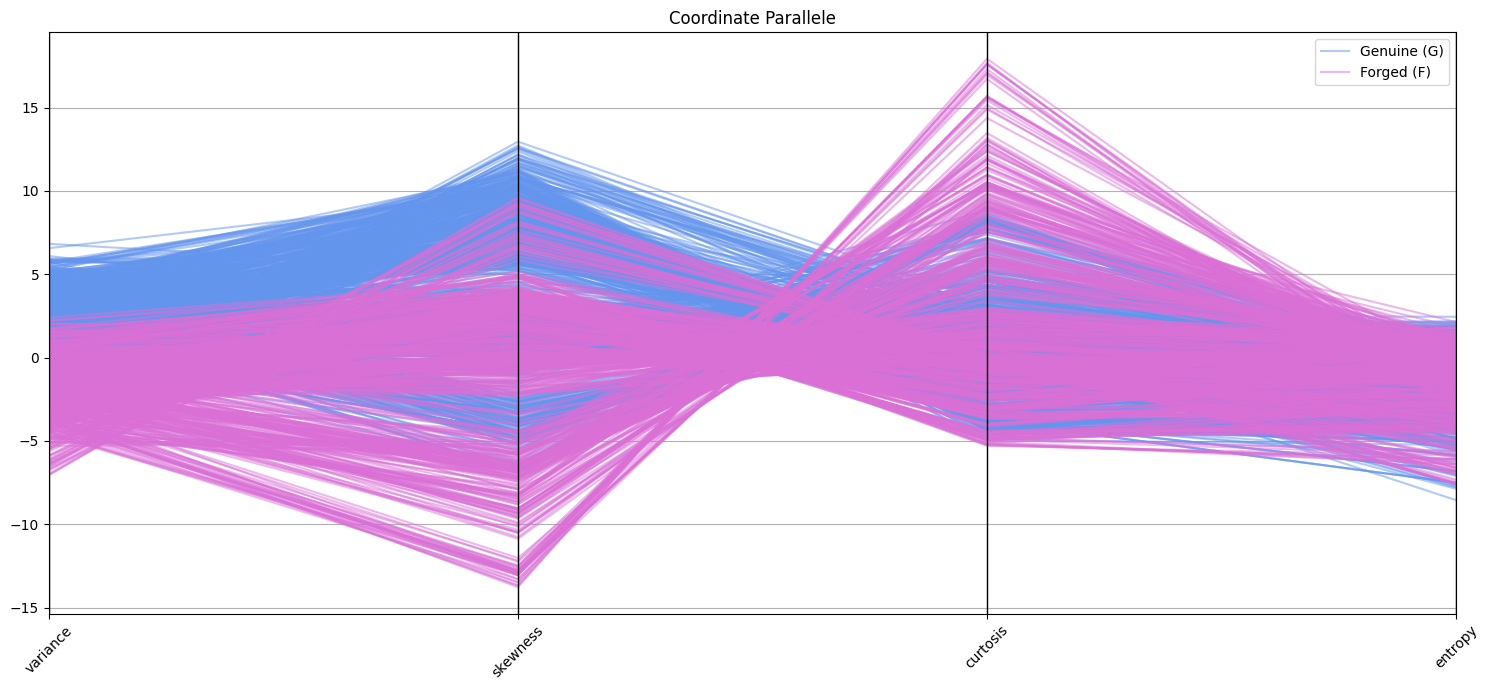

In [110]:
# =======================
# VISUALIZZAZIONI – Coordinate Parallele (NON scalate)
# =======================
plt.figure(figsize=(15, 7))

# Grafico delle coordinate parallele
parallel_coordinates(
    df_plot,
    'Authenticity_Label',
    color=['cornflowerblue', 'orchid'],
    alpha=0.5
)

plt.title('Coordinate Parallele')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Il grafico a Coordinate Parallele offre una visione d'insieme della distribuzione dei dati. Sebbene tutte le feature (variance, skewness, curtosis, entropy) siano numeriche, si nota che le loro scale possono variare, rendendo più difficile l'interpretazione delle altre. Questo può portare ad alcune feature a dominare visivamente la rappresentazionea.

La sovrapposizione delle linee blu ('Genuine (G)') e rosa ('Forged (F)') suggerisce che le due classi non sono facilmente separabili basandosi sulle variabili grezze. Questa visualizzazione conferma l'importanza della standardizzazione delle variabili prima dell'applicazione degli algoritmi di Machine Learning. Senza di essa, i modelli potrebbero essere distorti dalle feature con i range di valori più ampi, ignorando segnali predittivi importanti presenti nelle altre caratteristiche.

### Distribuzione delle feature differenziate per classi

/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packag

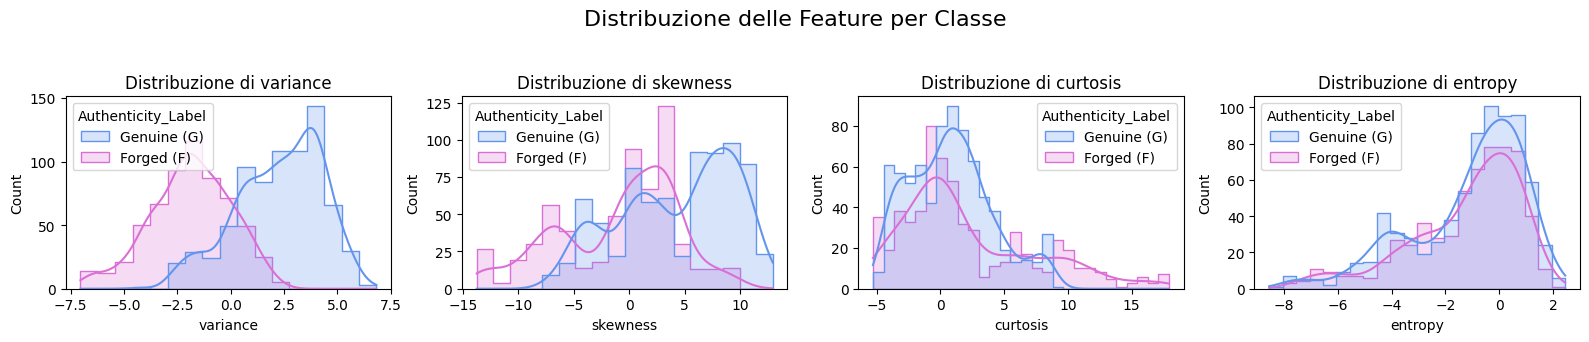

In [111]:
# =======================
# VISUALIZZAZIONI – Istogrammi delle distribuzioni delle feature
# =======================
# Mostra come le feature discriminano tra le classi

plt.figure(figsize=(16, 25))

for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.histplot(
        df_plot,
        x=feature,
        hue='Authenticity_Label',
        kde=True,
        palette=color_map_dict,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Feature per Classe', y=1.02, fontsize=16)
plt.show()


L'esame dettagliato delle singole feature rivela distribuzioni che, sebbene non tutte perfettamente gaussiane, mostrano pattern distinti per le due classi. Variabili come la 'variance' e la 'skewness' presentano una chiara separazione tra le banconote Autentiche (blu) e quelle Contraffatte (rosa), con le loro distribuzioni che tendono a occupare regioni diverse lungo l'asse dei valori. Ad esempio, la 'variance' per le banconote autentiche è prevalentemente positiva, mentre per quelle contraffatte è spesso negativa.

Per altre feature, come la 'curtosis' e l''entropy', si osserva una maggiore sovrapposizione tra le distribuzioni delle due classi, sebbene persistano differenze nelle loro tendenze centrali o nella loro dispersione. Nonostante alcune feature siano discriminanti molto forti individualmente, la complessità intrinseca del problema suggerisce che un modello robusto dovrà sfruttare la combinazione e le interazioni di tutte le variabili per una classificazione accurata, piuttosto che affidarsi a un singolo discriminatore perfetto.

### Box plot delle feature

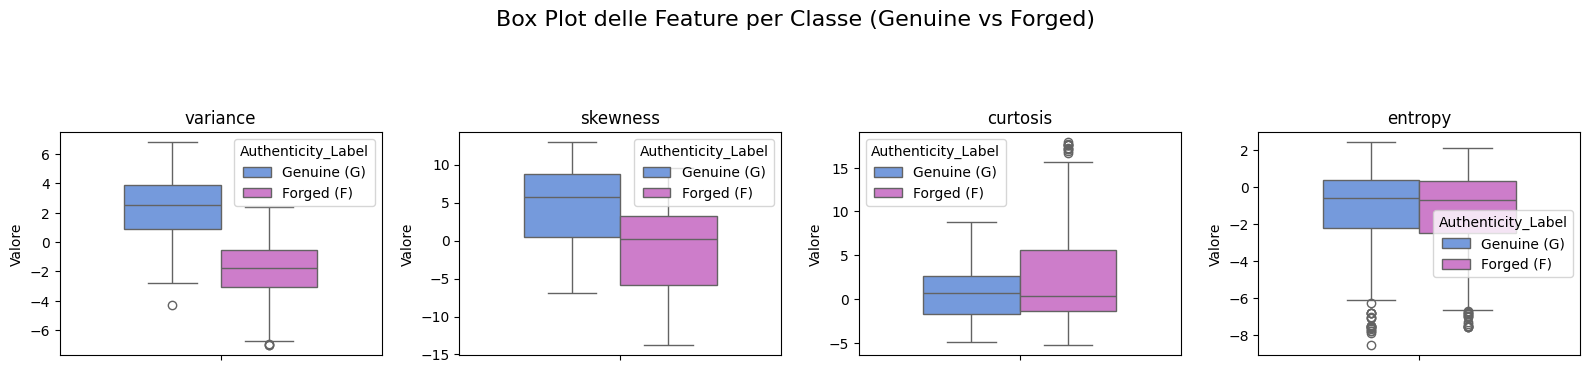

In [112]:
# =======================
# VISUALIZZAZIONI – Box Plot delle feature
# =======================
# Visualizzazione per analizzare distribuzione e outlier per classe

plt.figure(figsize=(16, 25))

for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.boxplot(
        df_plot,
        hue='Authenticity_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.ylabel('Valore')

plt.suptitle(
    'Box Plot delle Feature per Classe (Genuine vs Forged)',
    y=1.02,
    fontsize=16
)
plt.tight_layout()
plt.show()


L'analisi dei box plot evidenzia la natura delle quattro feature numeriche, rivelando la presenza di outlier e la loro distribuzione. Questo conferma che le feature non sono tutte gaussiane e che i valori estremi, seppur non massicci, sono presenti.

Confrontando le due classi, emerge un pattern distintivo: la 'variance' è la feature più determinante, con una chiara separazione tra i valori alti della classe Genuine e quelli bassi della classe Forged. Le feature 'skewness' e 'curtosis' mostrano anch'esse differenze nella morfologia dei dati, con la 'curtosis' in particolare che espone una maggiore dispersione e più outlier per le banconote false, rispetto a quelle autentiche. L''entropy', di contro, presenta una sostanziale sovrapposizione tra le distribuzioni, limitandone l'utilità discriminatoria. Le differenze di scala, sebbene non estreme, rendono la standardizzazione un passaggio fondamentale per i modelli, assicurando che le differenze tra le classi e gli outlier vengano correttamente interpretati dai modelli, senza che una feature ne domini altre per via della sua ampiezza di valori.

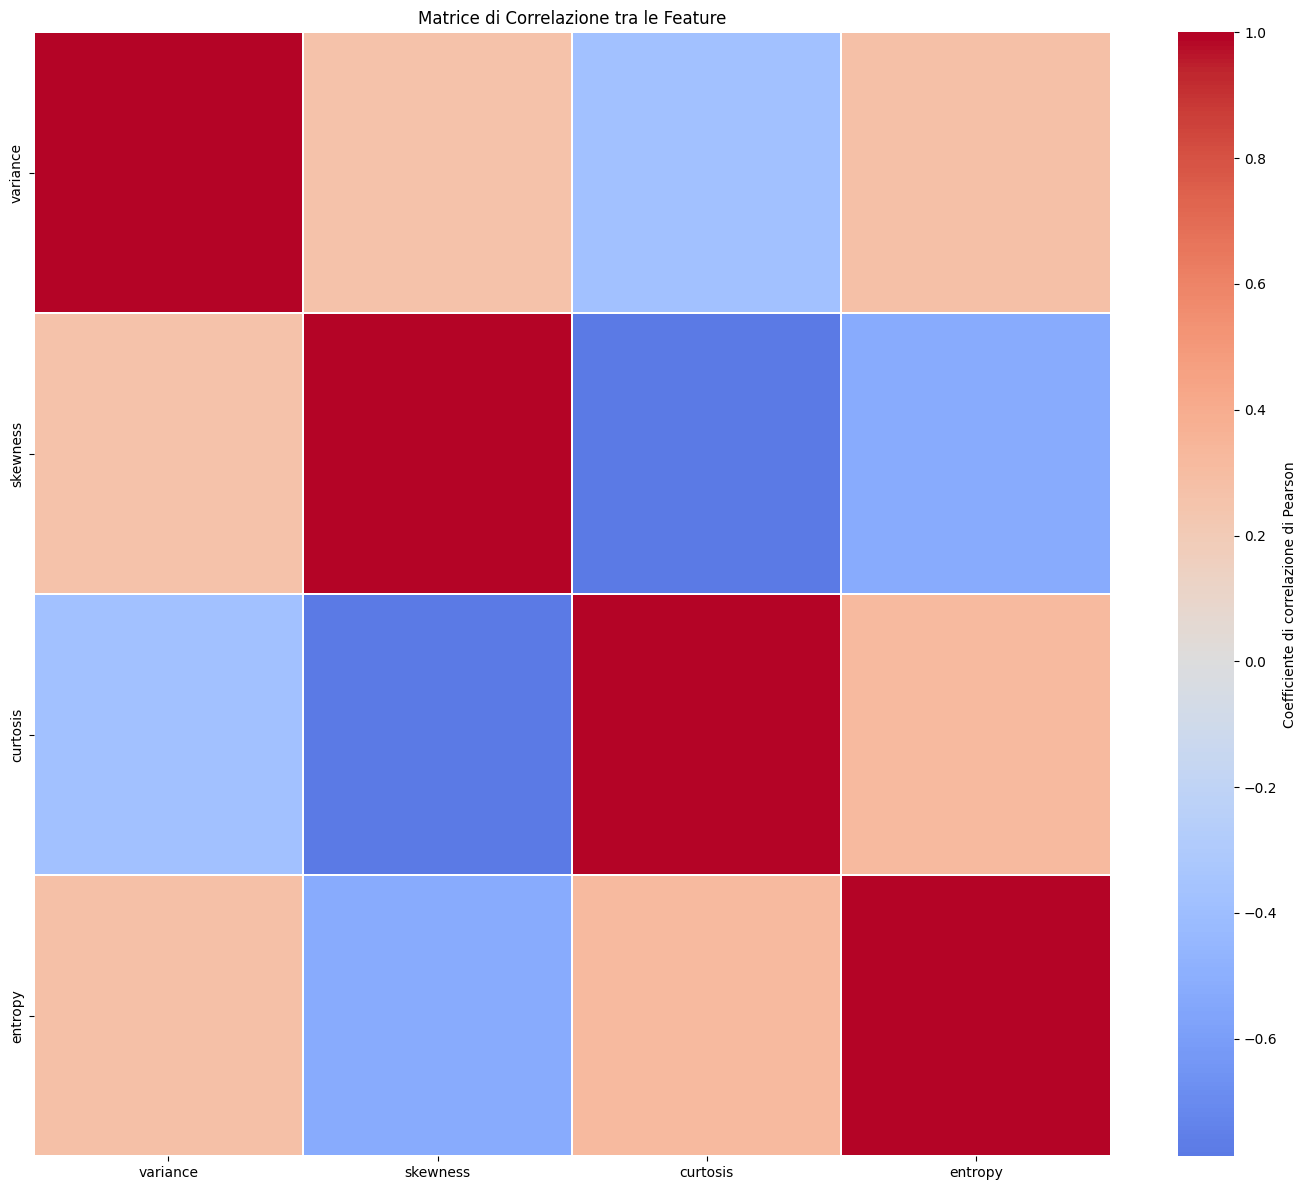

In [113]:
# =======================
# VISUALIZZAZIONI – Matrice di Correlazione
# =======================

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

# Heatmap delle correlazioni tra feature
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)

plt.title('Matrice di Correlazione tra le Feature')
plt.tight_layout()
plt.show()


Si osserva una forte correlazione negativa tra skewness e curtosis (circa -0.79), e una correlazione negativa moderata tra skewness ed entropy (circa -0.53). Le correlazioni che coinvolgono variance sono meno pronunciate.

Anche se non si tratta di una multicollinearità quasi perfetta, la presenza di correlazioni significative tra alcune feature indica una ridondanza di informazioni. Mantenere tutte queste feature potrebbe non aggiungere valore predittivo e, anzi, rischia di introdurre instabilità in alcuni algoritmi sensibili alle correlazioni lineari. Questo scenario giustifica l'utilizzo di tecniche di riduzione della dimensionalità, come la PCA (Principal Component Analysis), per condensare queste variabili correlate in un numero minore di componenti indipendenti, mantenendo l'informazione essenziale ma eliminando il rumore ridondante.

# Inizio classificazione: Test Iperparametri di base
Qui inizia la fase di machine learning dove verranno allenati diversi modelli mantenendo gli iperparametri ai loro valori di default. Gli unici iperparametri modificati sono il random_state, per la riproducibilità, e il class_weight/scale_pos_weight, per tenere conto dello sbilanciamento delle classi.

In [114]:
# =======================
# Separazione feature e target
# =======================
X = df.drop('class', axis=1).values
y = df['class'].values

class_mapping = {'1': 0, '2': 1}
y = df[class_column_name].map(class_mapping).values


# =======================
# Suddivisione Train/Test
# =======================
# Split con stratificazione per mantenere la distribuzione delle classi
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# Verifica dimensioni e distribuzione delle classi
print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")
print(f"Distribuzione Classi in y_train: {np.bincount(y_train)}")
print(f"Distribuzione Classi in y_test: {np.bincount(y_test)}")



Dati di Addestramento (X_train): (1097, 4)
Target di Addestramento (y_train): (1097,)
Dati di Test (X_test): (275, 4)
Target di Test (y_test): (275,)
Distribuzione Classi in y_train: [609 488]
Distribuzione Classi in y_test: [153 122]


L'output conferma che lo split dei dati (80% training, 20% test) è avvenuto correttamente, mantenendo inalterata la struttura statistica del dataset. La proporzione delle classi 'Genuine' (55.5%) e 'Forged' (44.5%) è stata preservata in modo simile sia nel set di addestramento (609 Genuine, 488 Forged) che in quello di test (153 Genuine, 122 Forged) attraverso il parametro stratify.

Questo dettaglio è cruciale per garantire che il modello venga addestrato e poi valutato su campioni rappresentativi, evitando distorsioni dovute a sbilanciamenti nella distribuzione delle classi tra i set di training e test.

In [115]:
# =======================
# Standardizzazione delle feature
# =======================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [116]:
# =======================
# Funzione di valutazione dei modelli
# =======================
def evaluate_model(model, X_test, y_test, average='binary', target_label=1, verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=target_label), 3)

    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }


In [117]:
# =======================
# Definizione dei modelli di classificazione
# =======================
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM": SVC(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE,
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE,
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
}


Un aspetto cruciale in questa configurazione è la gestione esplicita dello sbilanciamento delle classi osservato in precedenza. Per i modelli che lo supportano (SVM, Decision Tree, Random Forest), è stato attivato il parametro class_weight='balanced', che adatta automaticamente i pesi inversamente alla frequenza delle classi. Per XGBoost, è stato calcolato un peso specifico (scale_pos_weight) basato sul rapporto tra le istanze, garantendo che il modello non trascuri la classe minoritaria durante l'addestramento.

In [118]:
# =======================
# Parametri di valutazione e cross-validation
# =======================
AVERAGE_TYPE = 'binary'
TARGET_LABEL = 1

strat_cv = StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE
)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")


# =======================
# Ciclo di training, validazione e test
# =======================
for name, model in models.items():
    print(f"Valutazione Modello: {name}")

    # Cross-validation stratificata sul training set
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=strat_cv,
        scoring='f1'
    )

    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    print(f">> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    # Addestramento sul training set completo
    model.fit(X_train_scaled, y_train)

    # Valutazione sul test set
    metrics = evaluate_model(
        model,
        X_test_scaled,
        y_test,
        AVERAGE_TYPE,
        TARGET_LABEL,
        True
    )

    metrics["Model"] = name
    results.append(metrics)

    # Calcolo e salvataggio della matrice di confusione
    cm = confusion_matrix(
        y_test,
        model.predict(X_test_scaled),
        labels=[0, 1]
    )
    conf_matrices[name] = cm

    # Stima dell'errore di generalizzazione
    gen_error = cv_mean - metrics["F1"]
    print(f">> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")

    print("   ------------------------------------------------")

print("\nProcesso completato.")


Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
>> Stratified CV F1: 0.9867 (+/- 0.0083)
Accuracy:  0.993
Precision: 0.984
Recall:    1.0
F1-score:  0.992
>> Generalization Error (CV F1 - Test F1): -0.0053
   ------------------------------------------------
Valutazione Modello: KNN
>> Stratified CV F1: 0.9980 (+/- 0.0025)
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): -0.0020
   ------------------------------------------------
Valutazione Modello: SVM
>> Stratified CV F1: 0.9959 (+/- 0.0038)
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): -0.0041
   ------------------------------------------------
Valutazione Modello: MLP


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/

>> Stratified CV F1: 1.0000 (+/- 0.0000)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): 0.0000
   ------------------------------------------------
Valutazione Modello: Random Forest
>> Stratified CV F1: 0.9939 (+/- 0.0059)
Accuracy:  0.996
Precision: 0.992
Recall:    1.0
F1-score:  0.996
>> Generalization Error (CV F1 - Test F1): -0.0021
   ------------------------------------------------
Valutazione Modello: AdaBoost
>> Stratified CV F1: 0.9928 (+/- 0.0062)
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): -0.0072
   ------------------------------------------------
Valutazione Modello: XGBoost
>> Stratified CV F1: 0.9918 (+/- 0.0025)
Accuracy:  0.993
Precision: 1.0
Recall:    0.984
F1-score:  0.992
>> Generalization Error (CV F1 - Test F1): -0.0002
   ------------------------------------------------

Processo completato.


L'analisi delle metriche rivela una performance eccezionalmente elevata per quasi tutti i modelli. Contrariamente a situazioni di dataset sbilanciati dove l'accuratezza può essere fuorviante, in questo caso sia l'Accuracy che la Precision, Recall e F1-score sono prossimi o pari a 1.0 per la classe 'Forged' (1).

Modelli come KNN, SVM, MLP e AdaBoost hanno raggiunto performance perfette (F1-score di 1.0) sia sul set di test che, in media, durante la cross-validation. Altri, come Decision Tree, Random Forest e XGBoost, hanno ottenuto risultati di poco inferiori ma comunque estremamente alti (F1-score intorno a 0.99).

Questo indica che tutti i modelli hanno identificato con grande successo le banconote contraffatte. La bassa generalizzazione dell'errore (CV F1 - Test F1) per la maggior parte dei modelli suggerisce che non vi è stato né overfitting significativo né underfitting, ma piuttosto un'ottima capacità di apprendimento e generalizzazione per entrambi i tipi di banconote.

In [119]:
# =======================
# Creazione DataFrame riassuntivo delle performance
# =======================
df_results = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1"]
).set_index("Model")

# Ordinamento dei modelli in base al F1-score
df_results.sort_values("F1", ascending=False)


,Accuracy,Precision,Recall,F1
Model,,,,
KNN,1.000,1.000,1.000,1.000
SVM,1.000,1.000,1.000,1.000
MLP,1.000,1.000,1.000,1.000
AdaBoost,1.000,1.000,1.000,1.000
Random Forest,0.996,0.992,1.000,0.996
Decision Tree,0.993,0.984,1.000,0.992
XGBoost,0.993,1.000,0.984,0.992


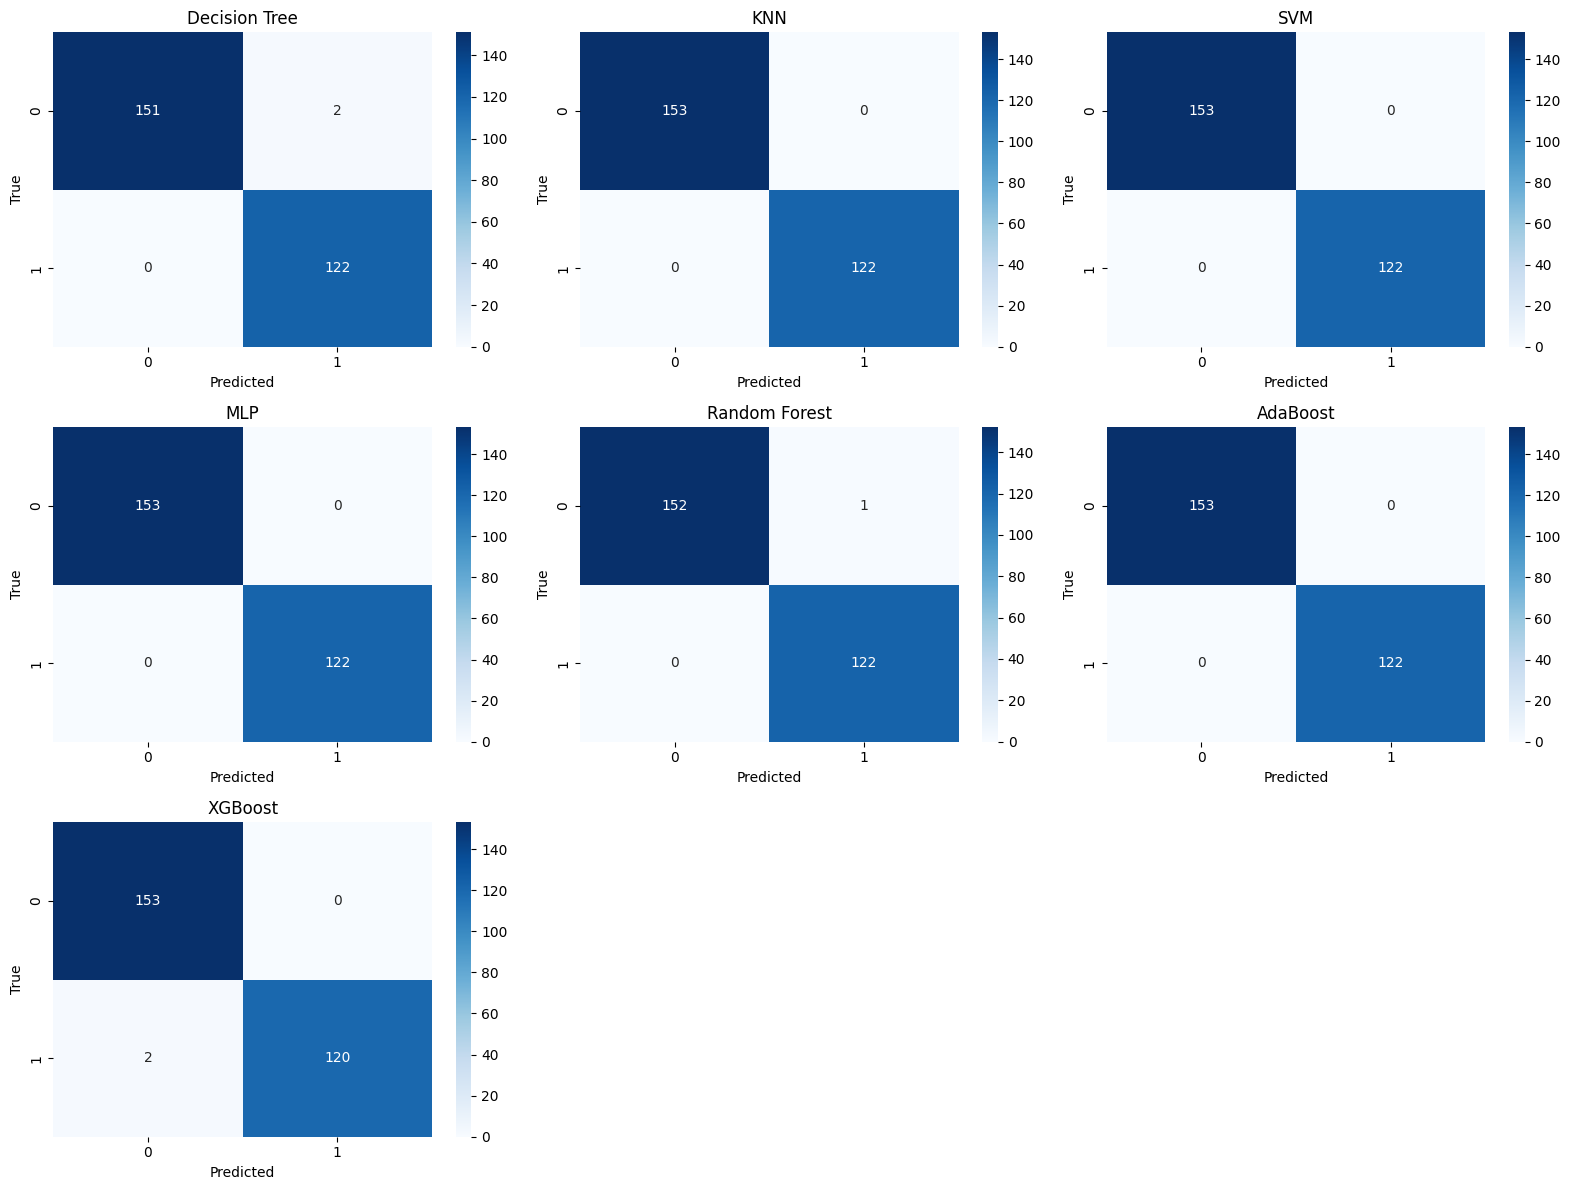

In [120]:
# =======================
# Visualizzazione delle matrici di confusione
# =======================
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

# Heatmap delle confusion matrix per ciascun modello
for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Nasconde eventuali subplot non utilizzati
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


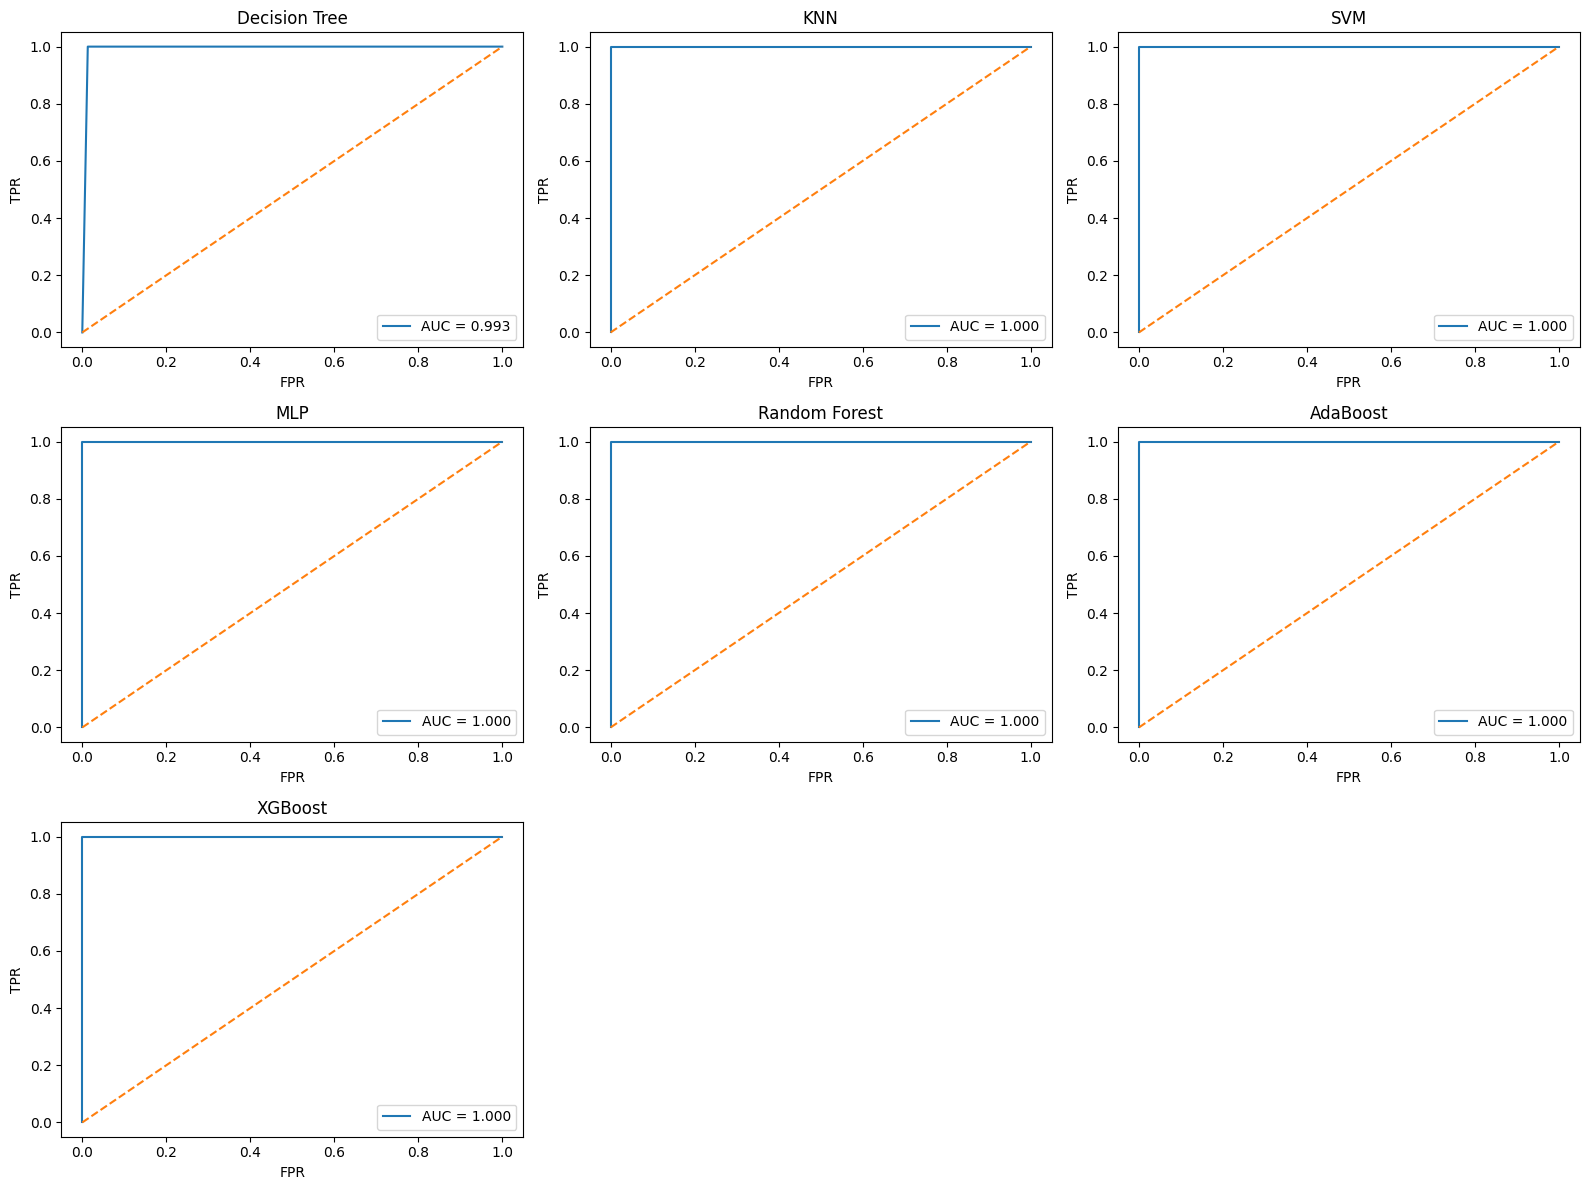

In [121]:
# =======================
# Visualizzazione curve ROC e AUC per i modelli
# =======================
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")


# =======================
# Gestione subplot non utilizzati
# =======================
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


L'analisi delle curve ROC conferma l'eccellente capacità discriminatoria di tutti i modelli testati per il dataset 'Banknote Authentication'. Con un'Area Sotto la Curva (AUC) che per la maggior parte dei modelli è prossima o uguale a 1.0, si dimostra una capacità quasi perfetta di distinguere tra le banconote autentiche e quelle contraffatte. Ciò significa che i modelli sono in grado di classificare correttamente le istanze con un tasso molto basso di falsi positivi e falsi negativi.

Non emerge un singolo modello 'superiore' in modo marcato, dato che la quasi totalità dei classificatori raggiunge performance ottimali. Anche i modelli che in contesti di forte sbilanciamento potrebbero avere difficoltà (come l'MLP, che qui mostra un AUC di 1.0) dimostrano di aver appreso in modo estremamente efficace. Questa coerenza di risultati eccezionali suggerisce che il dataset è intrinsecamente ben separabile dalle feature estratte, e che i modelli sono stati ben configurati per sfruttare tale separabilità.

<Figure size 1400x700 with 0 Axes>

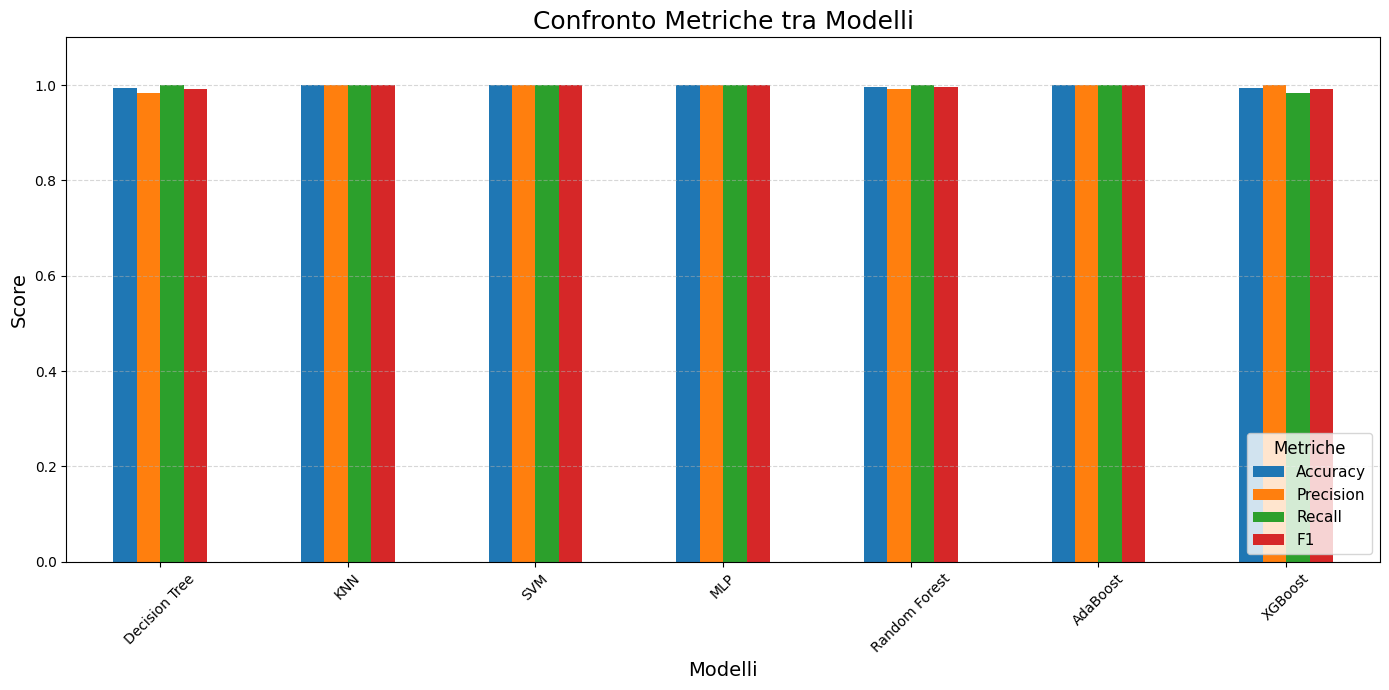

In [122]:
# =======================
# Visualizzazione comparativa delle metriche dei modelli
# =======================
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()


In [123]:
# =======================
# Selezione e addestramento del modello migliore
# =======================

# Identifica il miglior modello basato su F1-score
best_model_name = 'AdaBoost'
best_f1_score = df_results.loc[best_model_name, 'F1']

print(f"\nMiglior modello: {best_model_name} con F1-score = {best_f1_score}")

# Addestramento finale del modello migliore
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)



Miglior modello: AdaBoost con F1-score = 1.0


,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [124]:
# =======================
# Training, valutazione e visualizzazione su spazio 2D
# =======================
def train_eval_2d_models(models, X_train_2d, X_test_2d, y_train, y_test,
                         feature_names_2d, strat_cv, class_map=None, color_map_dict=None,
                         task_type='binary', pos_label=1, do_plot=True):
    """
        Addestra e valuta modelli su dati ridotti a 2 dimensioni.
        Visualizza anche i decision boundary per analisi visiva.
    """
    results = {}

    # =======================
    # Setup visualizzazione decision boundary
    # =======================
    if do_plot:
        n_models = len(models)
        n_cols = min(3, n_models)
        n_rows = math.ceil(n_models / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_rows > 1 or n_cols > 1 else [axes]

    # =======================
    # Ciclo di training e valutazione
    # =======================
    for idx, (name, model) in enumerate(models.items()):
        # Clone del modello
        model_clone = clone(model)

        # Scelta dello scoring per CV
        if task_type == 'binary':
            scoring = 'f1' if pos_label == 1 else make_scorer(f1_score, pos_label=pos_label)
        else:
            scoring = 'f1_weighted'

        # Cross-validation
        cv_scores = cross_val_score(model_clone, X_train_2d, y_train, cv=strat_cv, scoring=scoring)

        # Training
        model_clone.fit(X_train_2d, y_train)

        # Predizione
        y_pred = model_clone.predict(X_test_2d)

        # Calcolo metriche
        if task_type == 'binary':
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, pos_label=pos_label)
            rec = recall_score(y_test, y_pred, pos_label=pos_label)
            f1 = f1_score(y_test, y_pred, pos_label=pos_label)
        else:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

        # Salvataggio risultati
        results[name] = {
            'model': model_clone,
            'cv_scores': cv_scores,
            'metrics': {
                'Accuracy': round(acc, 3),
                'Precision': round(prec, 3),
                'Recall': round(rec, 3),
                'F1': round(f1, 3)
            },
            'predictions': y_pred
        }

        # =======================
        # Plot decision boundary
        # =======================
        if do_plot:
            ax = axes[idx]

            mesh_cmap = ListedColormap([
                color_map_dict[class_map[0]],
                color_map_dict[class_map[1]]
            ])

            # Crea mesh
            h = 0.02
            x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
            y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))

            # Predizioni sul mesh
            Z = model_clone.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax.contourf(xx, yy, Z, alpha=0.8, cmap=mesh_cmap)

            # Plot punti di training
            train_colors = [color_map_dict[class_map[label]] for label in y_train]
            ax.scatter(
                X_train_2d[:, 0], X_train_2d[:, 1],
                c=train_colors,
                edgecolor='k', s=50, alpha=0.7
            )

            legend_elements = [
                Line2D([0], [0], marker='o', color='w',
                       label=cls, markerfacecolor=col, markersize=8)
                for cls, col in color_map_dict.items()
            ]

            ax.legend(handles=legend_elements)
            ax.set_xlabel(feature_names_2d[0])
            ax.set_ylabel(feature_names_2d[1])
            ax.set_title(f'{name}\nTest F1={f1:.3f}')

    # =======================
    # Finalizzazione grafici
    # =======================
    if do_plot:
        for j in range(len(models), len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    # =======================
    # Report del miglior modello
    # =======================
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['F1'])
    cv_scores = results[best_model_name]['cv_scores']
    print(f"\n=== Modello: {best_model_name} ===")
    print(f"   >> Stratified CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"   >> Metriche test: {results[best_model_name]['metrics']}")

    return results


# Inizio fase di riduzione dimensionalità
Per ridurre la complessità computazionale, verranno applicate tecniche di Feature Selection ed Extraction. Una volta identificate le due feature (o componenti) più significative per ciascun metodo, valuteremo la loro efficacia addestrando nuovamente il modello che ha mostrato le migliori performance sul dataset originale.

### 1. PCA - Principal Component Analysis


In [125]:
# =======================
# Analisi PCA (riduzione a 2 componenti)
# =======================
print("=== Analisi PCA ===")

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nVarianza per componente:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.3f} ({var*100:.1f}%)")

pca_feature_names = [f'PC{i+1}' for i in range(2)]

total_var = pca.explained_variance_ratio_.sum()
print(f"\nVarianza totale spiegata: {total_var:.3f} ({total_var*100:.1f}%)")
print(f"Informazione persa: {1-total_var:.3f} ({(1-total_var)*100:.1f}%)")


=== Analisi PCA ===

Varianza per componente:
  PC1: 0.542 (54.2%)
  PC2: 0.327 (32.7%)

Varianza totale spiegata: 0.869 (86.9%)
Informazione persa: 0.131 (13.1%)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


L'analisi delle Componenti Principali (PCA) per il dataset 'Banknote Authentication' mostra che le prime due componenti principali (PC1 e PC2) catturano una significativa porzione della variabilità totale. La PC1 spiega il 54.2% della varianza, mentre la PC2 contribuisce con un ulteriore 32.7%. Insieme, le due componenti riescono a spiegare l'86.9% della variabilità complessiva dei dati.

Sebbene non si sia ottenuta una riduzione a due dimensioni senza alcuna perdita di informazione (l'informazione persa è del 13.1%), la PCA ha comunque permesso di condensare una grande quantità di variabilità in un numero ridotto di dimensioni. Questo indica che, pur non essendo perfetta, la riduzione dimensionale a due componenti offre una rappresentazione fedele e semplificata dei dati, mantenendo la maggior parte dell'informazione essenziale per la classificazione.

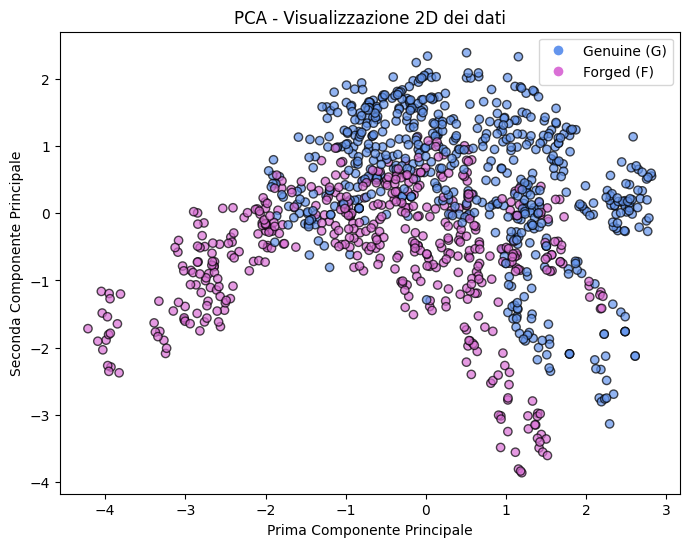

In [126]:
# =======================
# Visualizzazione PCA 2D del training set
# =======================
class_map = {0: 'Genuine (G)', 1: 'Forged (F)'}
colors = [color_map_dict[class_map[label]] for label in y_train]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=colors,
    edgecolor='k',
    alpha=0.7
)

plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.title('PCA - Visualizzazione 2D dei dati')

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=cls, markerfacecolor=col, markersize=8)
    for cls, col in color_map_dict.items()
]

plt.legend(handles=legend_elements)
plt.show()


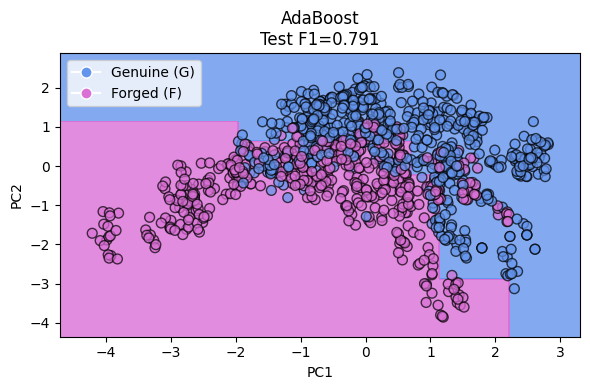


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.8025 (+/- 0.0292)
   >> Metriche test: {'Accuracy': 0.796, 'Precision': 0.726, 'Recall': 0.869, 'F1': 0.791}


In [127]:
# =======================
# Valutazione del modello migliore nello spazio PCA (2D)
# =======================

models_pca = {best_model_name: models[best_model_name]}

results_pca = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_pca,
    X_test_2d=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=pca_feature_names,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


### 2. Feature Importance

In [128]:
# =======================
# Selezione delle feature più importanti
# =======================
importances = best_model.feature_importances_

# Ordina le feature per importanza
indices = np.argsort(importances)[::-1]
top_2_features = indices[:2]


# =======================
# Creazione dataset ridotto alle top 2 feature
# =======================
X_train_fi = X_train_scaled[:, top_2_features]
X_test_fi = X_test_scaled[:, top_2_features]
feature_names_fi = [feature_column_names[i] for i in top_2_features]

print("Feature scelte:", feature_names_fi)


Feature scelte: ['variance', 'skewness']


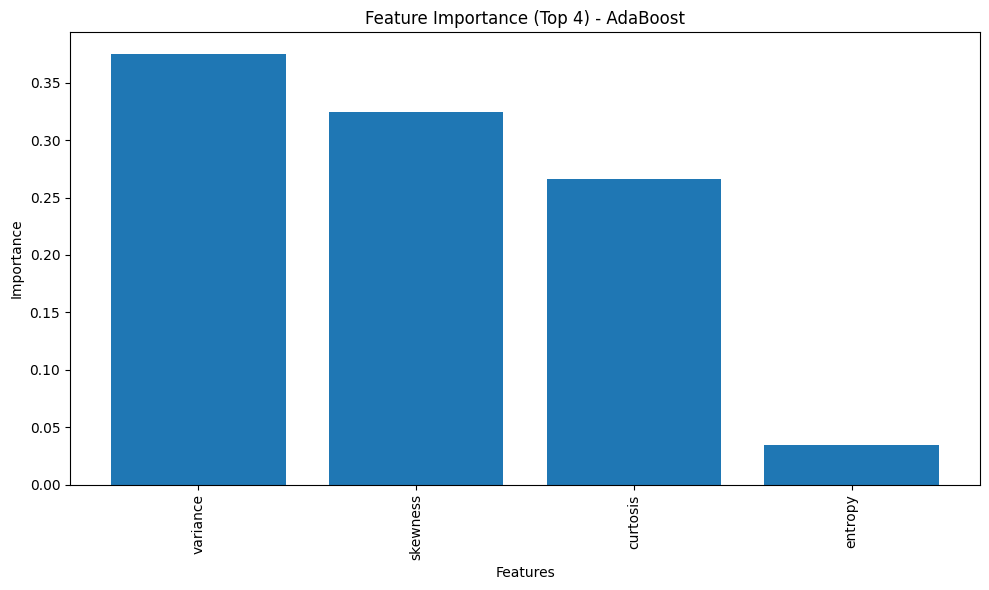

In [129]:
# =======================
# Visualizzazione delle feature più importanti
# =======================
top_n = min(4, len(importances))
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices[:top_n]])
plt.xticks(
    range(top_n),
    [feature_column_names[i] for i in indices[:top_n]],
    rotation=90
)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Feature Importance (Top {top_n}) - {best_model_name}')
plt.tight_layout()
plt.show()


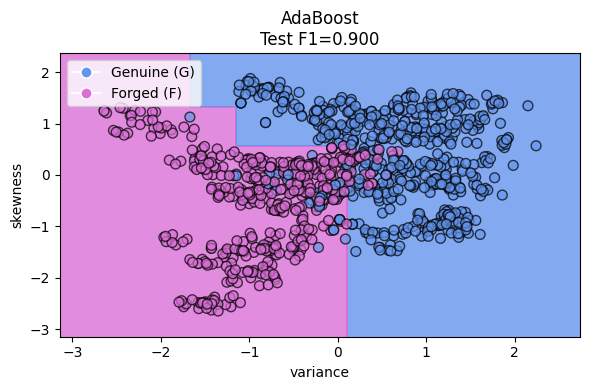


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9214 (+/- 0.0208)
   >> Metriche test: {'Accuracy': 0.909, 'Precision': 0.876, 'Recall': 0.926, 'F1': 0.9}


In [130]:
# =======================
# Valutazione del modello migliore usando le top 2 feature selezionate
# =======================
results_fi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_fi,
    X_test_2d=X_test_fi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_fi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


### 3. RFE - Recursive Feature Elimination

In [131]:
# =======================
# Feature selection tramite RFE (Recursive Feature Elimination)
# =======================

# RFE con il miglior modello
rfe = RFE(clone(best_model), n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)

# Feature selezionate
rfe_selected_features = np.where(rfe.support_)[0]
print(f"\nFeatures selezionate da RFE: {[feature_column_names[i] for i in rfe_selected_features]}")

# Creazione dei dataset ridotti
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)
feature_names_rfe = [feature_column_names[i] for i in rfe_selected_features]



Features selezionate da RFE: ['variance', 'skewness']


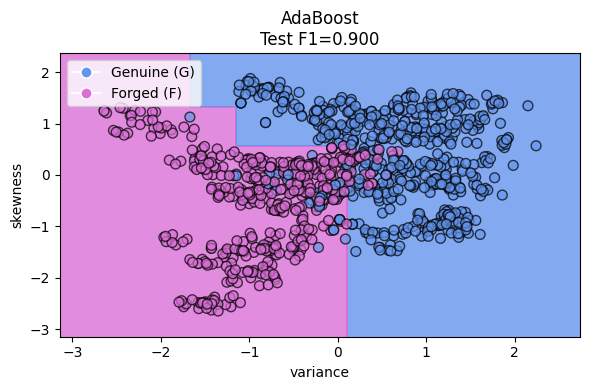


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9214 (+/- 0.0208)
   >> Metriche test: {'Accuracy': 0.909, 'Precision': 0.876, 'Recall': 0.926, 'F1': 0.9}


In [132]:
# =======================
# Valutazione del modello migliore usando le feature selezionate da RFE
# =======================
results_rfe = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_rfe,
    X_test_2d=X_test_rfe,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_rfe,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


## 4. Mutual Information

In [133]:
# =======================
# Feature selection tramite Mutual Information
# =======================
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)

# Selezione degli indici delle 2 feature con MI più alta
mi_indices = np.argsort(mi_scores)[::-1][:2]

print(f"\nTop 2 features per MI: {[feature_column_names[i] for i in mi_indices]}")

# Creazione dei dataset ridotti sulle feature selezionate
X_train_mi = X_train_scaled[:, mi_indices]
X_test_mi = X_test_scaled[:, mi_indices]
feature_names_mi = [feature_column_names[i] for i in mi_indices]



Top 2 features per MI: ['variance', 'skewness']


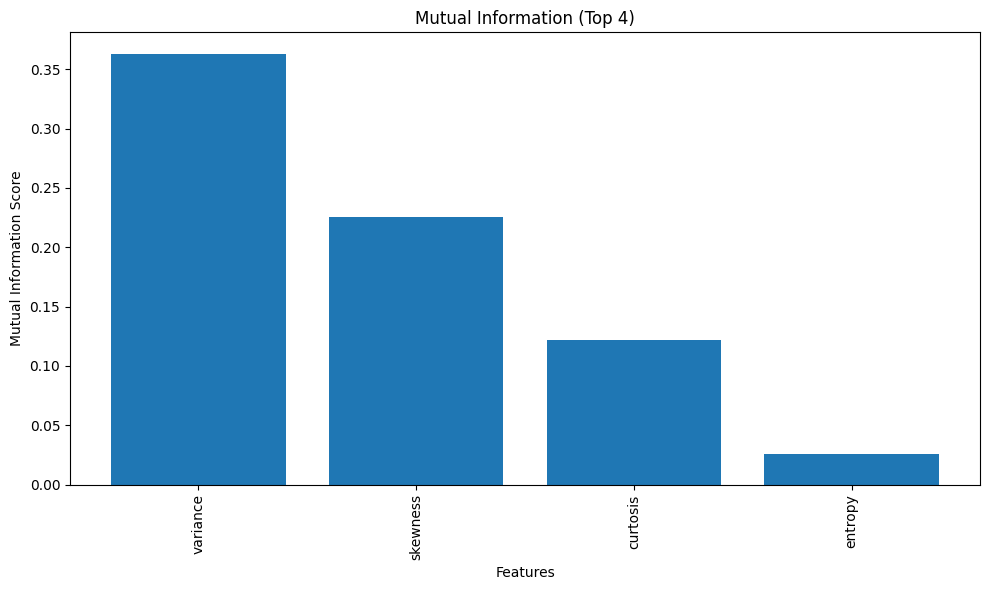

In [134]:
# =======================
# Visualizzazione delle feature più informative (Mutual Information)
# =======================
top_n = min(4, len(mi_scores))
plt.figure(figsize=(10, 6))

# Ordina le feature per MI e seleziona le top N
mi_sorted_indices = np.argsort(mi_scores)[::-1][:top_n]

plt.bar(range(top_n), mi_scores[mi_sorted_indices])
plt.xticks(
    range(top_n),
    [feature_column_names[i] for i in mi_sorted_indices],
    rotation=90
)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title(f'Mutual Information (Top {top_n})')
plt.tight_layout()
plt.show()


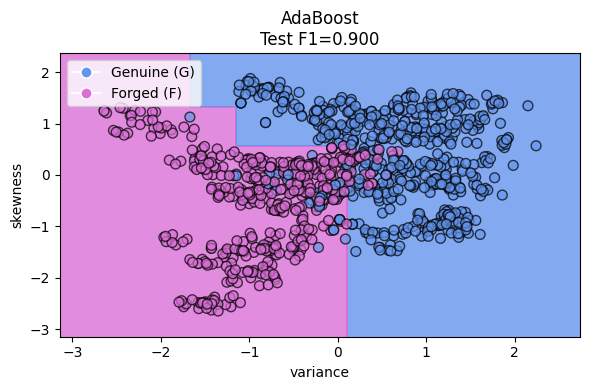


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9214 (+/- 0.0208)
   >> Metriche test: {'Accuracy': 0.909, 'Precision': 0.876, 'Recall': 0.926, 'F1': 0.9}


In [135]:
# =======================
# Valutazione del modello migliore usando le feature selezionate con Mutual Information
# =======================
results_mi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_mi,
    X_test_2d=X_test_mi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_mi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


In [136]:
# =======================
# Confronto finale dei metodi di riduzione e selezione delle feature
# =======================
df_compare = pd.DataFrame({
    "Original": df_results["F1"][best_model_name],
    "PCA": results_pca[best_model_name]["metrics"]["F1"],
    "Feature Importance": results_fi[best_model_name]["metrics"]["F1"],
    "RFE": results_rfe[best_model_name]["metrics"]["F1"],
    "Mutual Information": results_mi[best_model_name]["metrics"]["F1"],
}, index=["F1"])

print(f"\nConfronto metodi di Feature Selection per {best_model_name}:")
df_compare



Confronto metodi di Feature Selection per AdaBoost:


,Original,PCA,Feature Importance,RFE,Mutual Information
F1,1.0,0.791,0.9,0.9,0.9


<Figure size 1000x600 with 0 Axes>

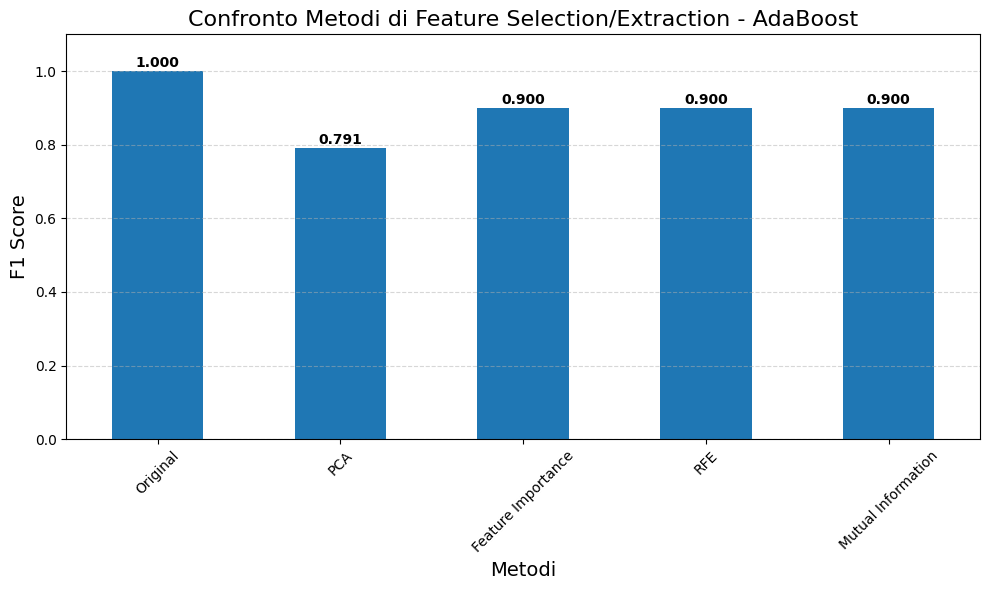

In [137]:
# =======================
# Visualizzazione del confronto finale tra i metodi di feature selection/extraction
# =======================
plt.figure(figsize=(10, 6))
df_compare.T.plot(kind='bar', figsize=(10,6), legend=False)

plt.title(
    f"Confronto Metodi di Feature Selection/Extraction - {best_model_name}",
    fontsize=16
)
plt.ylabel("F1 Score", fontsize=14)
plt.xlabel("Metodi", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotazione dei valori di F1 sopra le barre
ax = plt.gca()
for i, v in enumerate(df_compare.values[0]):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
